# BiLSTM + Attention

## 一.预处理

### 1.分词操作定义

In [1]:
import jieba
import re
import numpy as np

In [2]:

def tokenize(text):
    """
    带有语料清洗功能的分词函数, 包含数据预处理, 可以根据自己的需求重载
    """
    text = re.sub("\{%.+?%\}", " ", text)           # 去除 {%xxx%} (地理定位, 微博话题等)
    text = re.sub("@.+?( |$)", " ", text)           # 去除 @xxx (用户名)
    text = re.sub("【.+?】", " ", text)              # 去除 【xx】 (里面的内容通常都不是用户自己写的)
    icons = re.findall("\[.+?\]", text)             # 提取出所有表情图标
    text = re.sub("\[.+?\]", "IconMark", text)      # 将文本中的图标替换为`IconMark`

    tokens = []
    for k, w in enumerate(jieba.lcut(text)):
        w = w.strip()
        if "IconMark" in w:                         # 将IconMark替换为原图标
            for i in range(w.count("IconMark")):
                tokens.append(icons.pop(0))
        elif w and w != '\u200b' and w.isalpha():   # 只保留有效文本
                tokens.append(w)
    return tokens


def load_curpus(path):
    """
    加载语料库
    """
    data = []
    with open(path, "r", encoding="utf8") as f:
        for line in f:
            [_, seniment, content] = line.split(",", 2)
            content = tokenize(content)             # 分词
            data.append((content, int(seniment)))
    return data

### 2.数据加载

In [3]:
import pandas as pd
train_data = load_curpus("weibo2018/train.txt")
test_data = load_curpus("weibo2018/test.txt")
train_df = pd.DataFrame(train_data, columns=["content", "sentiment"])
test_df = pd.DataFrame(test_data, columns=["content", "sentiment"])

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\GHOSTA~1\AppData\Local\Temp\jieba.cache
Loading model cost 0.564 seconds.
Prefix dict has been built successfully.


#### 加载停用词

In [4]:
stopwords = []
with open("stopwords.txt", "r", encoding="utf8") as f:
    for w in f:
        stopwords.append(w.strip())

#### 加载之前训练好的FastText模型
注：见FastText.ipynb

In [5]:
from gensim.models import FastText
model = FastText.load("model/model_100.txt")

## 二.词向量生成

In [6]:
## 为保证输入神经网络的向量长度一致, 要对长度不足max_length的句子用零向量补齐, 对长度超过max_length的句子进行截断
max_length = 128

In [7]:
X_train, train_length, y_train = [], [], []
for content, sentiment in train_data:
    X, y = [], sentiment
    for w in content[:max_length]:
        if w in model.wv:
            X.append(np.expand_dims(model.wv[w], 0))
    if X:
        length = len(X)
        X = X + [np.zeros_like(X[0])] * (max_length - length)
        X = np.concatenate(X)
        X = np.expand_dims(X, 0)
        X_train.append(X)
        train_length.append(length)
        y_train.append(y)

In [8]:
X_test, test_length, y_test = [], [], []
for content, sentiment in test_data:
    X, y = [], sentiment
    for w in content[:max_length]:
        if w in model.wv:
            X.append(np.expand_dims(model.wv[w], 0))
    if X:
        length = len(X)
        X = X + [np.zeros_like(X[0])] * (max_length - length)
        X = np.concatenate(X)
        X = np.expand_dims(X, 0)
        X_test.append(X)
        test_length.append(length)
        y_test.append(y)

## 三.Attention+BiLSTM


### 1.Attention+BiLSTM网络搭建

In [9]:
## 由于tensorflow的Attention是基于Seq2Seq结构的，我这里也采用了这种结构，不过并没有使用“解码器”
import tensorflow as tf
from tensorflow.contrib import rnn, seq2seq
batch_size = 512
lr = 1e-3
hidden_size = 100

X = tf.placeholder(shape=(batch_size, max_length, 100), dtype=tf.float32, name="X")
L = tf.placeholder(shape=(batch_size), dtype=np.int32, name="L")
y = tf.placeholder(shape=(batch_size, 1), dtype=np.float32, name="y")
dropout = tf.placeholder(shape=(), dtype=np.float32, name="dropout")

with tf.variable_scope("lstm", reuse=tf.AUTO_REUSE):
    def lstm_cell(hidden_size, cell_id=0):
        # LSTM细胞生成器
        cell = rnn.LSTMCell(hidden_size, reuse=tf.AUTO_REUSE, name='cell%d' % cell_id)
        cell = rnn.DropoutWrapper(cell, output_keep_prob=dropout)
        return cell
    
    context = tf.get_variable("context", shape=(1, hidden_size))
    context = tf.tile(context, [batch_size, 1])
    
    # BiLSTM部分
    fw_cell = lstm_cell(hidden_size, 0)
    bw_cell = lstm_cell(hidden_size, 1)
    fw_zero = fw_cell.zero_state(batch_size, tf.float32)
    bw_zero = fw_cell.zero_state(batch_size, tf.float32)
    
    # Seq2Seq版的dynamic_rnn
    encoder_output, encoder_states = tf.nn.bidirectional_dynamic_rnn(cell_fw=fw_cell,
                                                         cell_bw=bw_cell,
                                                         inputs=X,
                                                         sequence_length=L,
                                                         initial_state_fw=fw_zero,
                                                         initial_state_bw=bw_zero,
                                                         dtype=tf.float32)

   
    # Attention模块
    attention_context = tf.concat(encoder_output, axis=2)
    attention_mech = seq2seq.BahdanauAttention(hidden_size * 2,
                                                 memory=attention_context,
                                                 memory_sequence_length=L,
                                                 name="AttentionMechanism")
    attention_cell = seq2seq.AttentionWrapper(cell=lstm_cell(hidden_size, 2),
                                                attention_mechanism=attention_mech,
                                                attention_layer_size=hidden_size,
                                                alignment_history=True,
                                                output_attention=True,
                                                name="AttentionCell")
    
    # Attention加权得到的context向量
    attention_zero = attention_cell.zero_state(batch_size, tf.float32)
    attention_output, attention_state = attention_cell.call(context, attention_zero)
    aligments = attention_state[3]
    
    
    
    # 用context向量直接用MLP做二分类
    W1 = tf.get_variable("W1", shape=(hidden_size, 50))
    b1 = tf.get_variable("b1", shape=(50,))
    W2 = tf.get_variable("W2", shape=(50, 1))
    b2 = tf.get_variable("b2", shape=(1,))
    fcn1 = tf.nn.xw_plus_b(attention_output, W1, b1)
    logists = tf.nn.xw_plus_b(fcn1, W2, b2)
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logists, labels=y))     # 交叉熵
    op = tf.train.AdamOptimizer(lr).minimize(loss)

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### 2.LSTM模型训练

In [10]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.6)
config = tf.ConfigProto(gpu_options=gpu_options)
sess = tf.Session(config=config)

In [11]:
total_step = 1001
step = 0
cursor = 0
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver(max_to_keep=1)
while step < total_step:
    _X, _L, _y = X_train[cursor: cursor + batch_size], train_length[cursor: cursor + batch_size], y_train[cursor: cursor + batch_size]
    cursor += batch_size
    if len(_X) < batch_size:
        cursor = batch_size - len(_X)
        _X += X_train[: cursor]
        _L += train_length[: cursor]
        _y += y_train[: cursor]
    _X = np.concatenate(_X)
    _L = np.reshape(np.array(_L, dtype=np.int32), (-1))
    _y = np.reshape(np.array(_y, dtype=np.float32), (batch_size, 1))
    _, l = sess.run([op, loss], feed_dict={X: _X, L:_L, y: _y, dropout:.75})
    if step % 100 == 0:
        print("step:", step, " loss:", l)
        saver.save(sess,'model/attention/model', global_step=step)
    step += 1

step: 0  loss: 1.0102375
step: 100  loss: 0.3220744
Instructions for updating:
Use standard file APIs to delete files with this prefix.
step: 200  loss: 0.15343997
step: 300  loss: 0.064337425
step: 400  loss: 0.066639856
step: 500  loss: 0.004803976
step: 600  loss: 0.005848105
step: 700  loss: 0.0017513898
step: 800  loss: 0.00091386255
step: 900  loss: 0.0065245815
step: 1000  loss: 0.0010330456


### 3.效果测试

#### 测试集测试

In [12]:
_X = np.concatenate(X_test + [np.zeros_like(X_test[0])] * (batch_size - len(X_test)))
_L = np.array(test_length + [1] * (batch_size - len(test_length)))

In [13]:
result = sess.run(tf.nn.sigmoid(logists), feed_dict={X: _X, L: _L, dropout:1.})
prediction = []
for i in result[:len(X_test)]:
    if i > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)

              precision    recall  f1-score   support

           0       0.77      0.81      0.79       155
           1       0.91      0.89      0.90       345

    accuracy                           0.86       500
   macro avg       0.84      0.85      0.84       500
weighted avg       0.87      0.86      0.86       500

准确率: 0.864


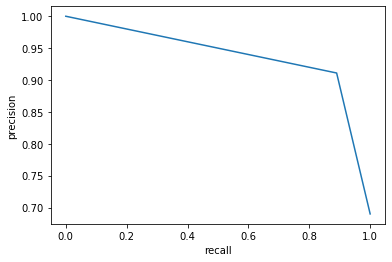

In [17]:
from sklearn import metrics
import matplotlib.pyplot as plt
print(metrics.classification_report(y_test, prediction))
print("准确率:", metrics.accuracy_score(y_test, prediction))
precision,recall,threshold = metrics.precision_recall_curve(y_test, prediction)
plt.plot(recall,precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

In [19]:
print(recall, precision)

[1.         0.88985507 0.        ] [0.69       0.91097923 1.        ]


#### LSTM与Attention+BiLSTM效果对比

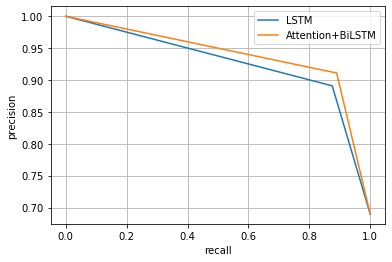

In [22]:
recall_lstm = [1, 0.87536232, 0]
precision_lstm = [0.69, 0.89085546, 1]
recall_lstm = np.array(recall_lstm)
precision_lstm = np.array(precision_lstm)

plt.grid()
plt.plot(recall_lstm, precision_lstm, label='LSTM')
plt.plot(recall, precision, label='Attention+BiLSTM')

plt.xlabel('recall')
plt.ylabel('precision')

plt.legend()
plt.show()

#### 实时输入测试

In [15]:
def processing(text):

    # 数据清洗部分
    text = re.sub("\{%.+?%\}", " ", text)           # 去除 {%xxx%} (地理定位, 微博话题等)
    text = re.sub("@.+?( |$)", " ", text)           # 去除 @xxx (用户名)
    text = re.sub("【.+?】", " ", text)              # 去除 【xx】 (里面的内容通常都不是用户自己写的)
    text = re.sub("\u200b", " ", text)              # '\u200b'是这个数据集中的一个bad case, 不用特别在意
    # 分词
    words = [w for w in jieba.lcut(text) if w.isalpha()]
    # 对否定词`不`做特殊处理: 与其后面的词进行拼接
    while "不" in words:
        index = words.index("不")
        if index == len(words) - 1:
            break
        words[index: index+2] = ["".join(words[index: index+2])]  # 列表切片赋值的酷炫写法
    # 用空格拼接成字符串
    result = " ".join(words)
    return result


In [63]:

strs = ["我永远喜欢东南大学",  
        "南京的冬天美得不行", 
        "某些建筑物丑得不行"]

data, data_length = [], []
for s in strs:
    vectors = []
    for w in processing(s).split(" ")[:max_length]:
        if w in model.wv:
            vectors.append(np.expand_dims(model.wv[w], 0))   # 将每个词替换为对应的词向量
    if vectors:
        length = len(vectors)
        vectors = vectors + [np.zeros_like(vectors[0])] * (max_length - length)
        vectors = np.concatenate(vectors)
        vectors = np.expand_dims(vectors, 0)
        data.append(vectors)
        data_length.append(length)

    
_data = np.concatenate(data + [np.zeros_like(data[0])] * (batch_size - len(data)))
_data_L = np.array(data_length + [1] * (batch_size - len(data_length)))    


result_data = sess.run(tf.nn.sigmoid(logists), feed_dict={X: _data, L: _data_L, dropout:1.})
prediction_data = []
for i in result_data[:len(data)]:
    if i > 0.5:
        prediction_data.append(1)
    else:
        prediction_data.append(0)
        
print('BiLSTM分析结果：')
print(result_data[:len(data)])
print(prediction_data)


BiLSTM分析结果：
[[1.0000000e+00]
 [9.9921453e-01]
 [2.1815300e-05]]
[1, 1, 0]


In [102]:
print("-"*44)
print("|              BiLSTM+Attention            |")
print("-"*44)
print("|     Input Text        |    Predicition   |")
print("-"*44)
for i in range(3):
    print("| \"{}\"  |   {:.10f}   |".format(strs[i],result_data[:len(data)][i][0]))
print("-"*44)

--------------------------------------------
|              BiLSTM+Attention            |
--------------------------------------------
|     Input Text        |    Predicition   |
--------------------------------------------
| "我永远喜欢东南大学"  |   1.0000000000   |
| "南京的冬天美得不行"  |   0.9992145300   |
| "某些建筑物丑得不行"  |   0.0000218153   |
--------------------------------------------
